# Post-Processing (General)

#### Updated: May 17, 2023

#  

Post-processing pipeline after stage 2 of Alouette processing (OCR processing stage):

In [206]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

In [207]:
rootDir = 'L:/DATA/Alouette_I/BATCH_I_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Functions:

In [208]:
def construct_timestamp(df_in):
    
    df_in['time_quality'] = 0
    
    #To the nearest second (time quality 1)
    df_in['month_day'] = pd.to_datetime(df_in['day_of_year'], format='%j').dt.strftime('%m-%d')
    df_in['month'] = df_in['month_day'].str.split('-').str[0]
    df_in['day'] = df_in['month_day'].str.split('-').str[1]
    df_in['Timestamp'] = pd.to_datetime(df_in[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
    df_in.loc[~df_in['Timestamp'].isnull(), 'time_quality'] = 1
    df_in_tq1 = df_in.loc[df_in['time_quality'] == 1]
    
    #To the nearest minute (time quality 2)
    df_in_not_tq1 = df_in.loc[df_in['time_quality'] != 1]
    df_in_not_tq1 = df_in_not_tq1.copy(deep=True)
    df_in_not_tq1['Timestamp'] = pd.to_datetime(df_in_not_tq1[['year', 'month', 'day', 'hour', 'minute']], format='%Y-%m-%d %H:%M:00')
    df_in_not_tq1.loc[~df_in_not_tq1['Timestamp'].isnull(), 'time_quality'] = 2
    df_in_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] == 2]
    
    #To the nearest hour (time quality 3)
    df_in_not_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] != 2]
    df_in_not_tq2 = df_in_not_tq2.copy(deep=True)
    df_in_not_tq2['Timestamp'] = pd.to_datetime(df_in_not_tq2[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00:00')
    df_in_not_tq2.loc[~df_in_not_tq2['Timestamp'].isnull(), 'time_quality'] = 3
    df_in_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] == 3]
    
    #To the nearest day (time quality 4)
    df_in_not_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] != 3]
    df_in_not_tq3 = df_in_not_tq3.copy(deep=True)
    df_in_not_tq3['Timestamp'] = pd.to_datetime(df_in_not_tq3[['year', 'month', 'day']], format='%Y-%m-%d 00:00:00')
    df_in_not_tq3.loc[~df_in_not_tq3['Timestamp'].isnull(), 'time_quality'] = 4
    df_in_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] == 4]
    
    df_in_not_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] != 4]
    df_in = pd.concat([df_in_tq1, df_in_tq2, df_in_tq3, df_in_tq4, df_in_not_tq4])
    
    return df_in

#  

#### Generate processed_inventory, concatenate stage 1 results - RUN BEFORE starting stage 2 processing (OCR processing stage):

Generate processed_inventory:

In [106]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

R014207711
R014207807
R014207808
R014207810
R014207811
R014207813
R014207817
R014207818
R014207819
R014207820
R014207822
R014207825
R014207826
R014207827
R014207828
R014207829
R014207830
R014207831
R014207833
R014207834
R014207835
R014207836
R014207837
R014207838
R014207839
R014207843
R014207886
R014207892
R014207941
R014207944
R014207945
R014207950
R014207952
R014207961
R014207963
R014207969
R028224481


In [107]:
print(len(df_inventory))
df_inventory.head()

1977


,Directory,Subdirectory,images,subdir_id
0,R014207711,24,256,R014207711_24
1,R014207711,25,499,R014207711_25
2,R014207711,27,96,R014207711_27
3,R014207711,28,103,R014207711_28
4,R014207711,29,341,R014207711_29


In [108]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

Concatenate stage 1 results:

In [109]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result-' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[1].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                    df_load = pd.DataFrame()
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)

Now saving the 100th result...
2161
Now saving the 200th result...
2370
Now saving the 300th result...
2370
Now saving the 400th result...
23901
Now saving the 500th result...


c:\DevSoftware\Anaconda38\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


62417
Now saving the 600th result...
93694
Now saving the 700th result...
123538
Now saving the 800th result...
151048
Now saving the 900th result...
177659
Now saving the 1000th result...
206601
Now saving the 1100th result...
233913
Now saving the 1200th result...
261344
Now saving the 1300th result...
292007
Now saving the 1400th result...
317822
Now saving the 1500th result...
346889
Now saving the 1600th result...
375871
Now saving the 1700th result...
405211
Now saving the 1800th result...


c:\DevSoftware\Anaconda38\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (17,20,24,25,26,27,28,29,30,31,34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


426003
Now saving the 1900th result...
432693
Now saving the 2000th result...


c:\DevSoftware\Anaconda38\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (24,25,26,27,28,29,30,31,34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


461842
Now saving the 2100th result...
493997
Now saving the 2200th result...
526529
Now saving the 2300th result...
560941
Now saving the 2400th result...
593524


In [110]:
df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
print(len(df_result))
df_result.sample(10)

600621


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,raw_coord,window_coord,mapping_Hz,mapping_km,details,Directory,Subdirectory,filename,station_code,station_number
517693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,"height: 814,width: 2150",R014207952,2762-4A,233.png,NaN,NaN
517168,1.649194,1234.482759,1.0,5.0,1.0,5.0,9.0,3.0,9.0,0.0,...,NaN,NaN,NaN,NaN,NaN,R014207952,2761-4A,206.png,NaN,NaN
574706,1.604839,1292.000000,1.0,3.0,1.0,4.0,9.0,0.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,R014207969,1311-18B,296.png,NaN,NaN
327276,1.600806,1677.142857,3.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,R014207835,4054-19A,251.png,NaN,NaN
175256,1.604839,1217.021277,0.0,0.0,2.0,2.0,0.0,4.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,R014207825,3752-19A,192.png,NaN,NaN
461103,6.753968,843.396226,1.0,4.0,3.0,2.0,8.0,0.0,9.0,3.0,...,NaN,NaN,NaN,NaN,NaN,R014207944,2043-3B,130.png,NaN,NaN
383189,1.500000,1379.591837,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,R014207838,4549-50,89.png,NaN,NaN
201027,1.508065,965.217391,4.0,2.0,2.0,3.0,3.0,3.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,R014207826,3902-12-2,314.png,NaN,NaN
348497,1.500000,5123.076923,1.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,R014207836,4730-50-2,114.png,NaN,NaN
394892,1.588710,1885.714286,4.0,4.0,3.0,2.0,3.0,3.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,R014207839,4109-43A,55.png,NaN,NaN


#  

#### Concatenate 'OCR pass' results - START HERE after stage 2 processeing (OCR processing stage):

In [209]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)

Now saving the 100th result...
30402
Now saving the 200th result...
61145
Now saving the 300th result...
93973
Now saving the 400th result...
130784
Now saving the 500th result...
167294
Now saving the 600th result...
198446
Now saving the 700th result...
230070
Now saving the 800th result...
262066
Now saving the 900th result...
294601
Now saving the 1000th result...
327891
Now saving the 1100th result...
362711
Now saving the 1200th result...
397569


#  

#### Reduce columns:

In [210]:
df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
print(len(df_result))
df_result.head()

418972


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,filename,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,station_code,station_number,rotated_metadata
0,1.5,816.666667,0.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.5,504.166667,0.0,0.0,1.0,1.0,0.0,2.0,0.0,2.0,...,10.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.5,920.833333,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,100.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,712.500000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,101.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.5,608.333333,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,...,102.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
381593,R014207974,784-B,345.png,num,1.770161,1409.433962,NaN,0.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167255,R014207942,1955-5A,79.png,num,1.729839,1655.555556,NaN,0.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378779,R014207974,770-A,343.png,num,1.963710,1420.833333,NaN,0.0,9.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78340,R014207844,2918-43B,17.png,loss,1.600806,1285.416667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bottom,True,NaN,NaN
379642,R014207974,776-B,34.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 740,width: 8038"
250177,R014207954,2227-18B,289.png,num,1.770161,656.250000,NaN,6.0,9.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
252771,R014207955,2846-50B,12.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 721,width: 1263"
203058,R014207948,1700-9B,101.png,num,5.027778,1413.725490,NaN,0.0,9.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
185792,R014207946,1825-1B,269.png,num,1.705645,1103.636364,NaN,1.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
277786,R014207958,2770-12A,239.png,num,1.600806,471.739130,NaN,1.0,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  

#### Split results into different metadata types (dot, num, num2):

In [212]:
df_result['processed_image_class'].unique()

array(['num', 'loss', 'outlier', 'num2', 'dot'], dtype=object)

In [213]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

19354


In [214]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

281336


In [215]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

34291


In [216]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

14355


In [217]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

69636


In [218]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

418972

#### num2 - check timestamp components, construct timestamp:

In [219]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
21893,65,301,16,35,57
66389,65.0,193.0,01,20,40
71207,65.0,307.0,22,20,44
252830,65.0,251.0,06,35,09
10202,66.0,33.0,19,39,21
252055,65.0,233,21,30,02
68848,66.0,33.0,04,59,06
66934,65.0,204.0,13.0,4.0,00
14252,66.0,059,08,34,6.0
67831,66,042,0.0,15,41


year:

<AxesSubplot:xlabel='year_OCR', ylabel='Count'>

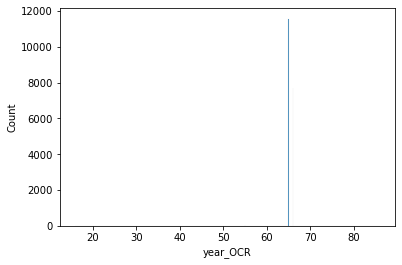

In [220]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [221]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [222]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
13533,1966.0,66.0
70994,1965.0,65.0
20822,1965.0,65.0
15371,1966.0,66.0
12312,1966.0,66.0
9740,1966.0,66.0
68494,1966.0,66.0
47638,1966.0,66.0
19532,1965.0,65.0
68848,1966.0,66.0


day:

<AxesSubplot:xlabel='day_of_year_OCR', ylabel='Count'>

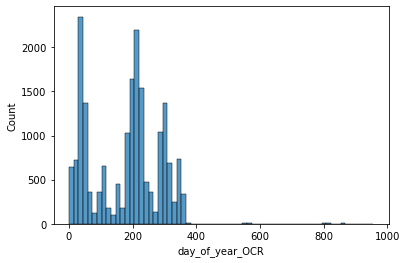

In [223]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [224]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
63345,282.0,282.0
18847,219.0,219.0
4040,43.0,43.0
38128,231.0,231.0
13744,44.0,44.0
71514,310.0,310.0
66630,201.0,201.0
67427,30.0,30.0
63124,283.0,283.0
40884,246.0,246.0


hour:

<AxesSubplot:xlabel='hour_OCR', ylabel='Count'>

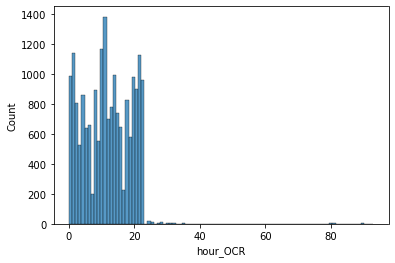

In [225]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [226]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
53865,16.0,16.0
12042,14.0,14.0
60130,10.0,10.0
253016,17.0,17.0
21248,9.0,9.0
21233,9.0,9.0
57659,0.0,0.0
252829,6.0,6.0
20529,10.0,10.0
30860,4.0,4.0


minute:

<AxesSubplot:xlabel='minute_OCR', ylabel='Count'>

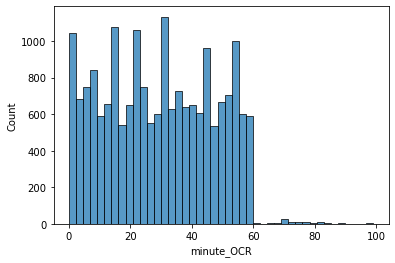

In [227]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [228]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
257770,0.0,0.0
11058,53.0,53.0
10587,18.0,18.0
24965,13.0,13.0
67208,29.0,29.0
16320,13.0,13.0
47545,36.0,36.0
22195,14.0,14.0
18011,13.0,13.0
257664,17.0,17.0


second:

<AxesSubplot:xlabel='second_OCR', ylabel='Count'>

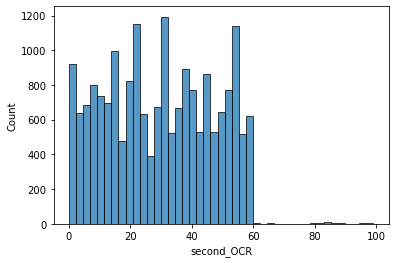

In [229]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [230]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
63345,44.0,44.0
19239,44.0,44.0
40966,35.0,35.0
58831,31.0,31.0
70108,41.0,41.0
59476,36.0,36.0
67294,12.0,12.0
36165,23.0,23.0
18637,29.0,29.0
36249,5.0,5.0


construct timestamp:

In [231]:
df_num2 = construct_timestamp(df_in=df_num2)
print(len(df_num2))

19354


In [232]:
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
59487,1965.0,07,29,22.0,33.0,31.0,1965-07-29 22:33:31,1
18033,1966.0,03,13,17.0,57.0,21.0,1966-03-13 17:57:21,1
10637,1966.0,02,12,20.0,44.0,5.0,1966-02-12 20:44:05,1
75534,1965.0,08,19,23.0,53.0,44.0,1965-08-19 23:53:44,1
47353,1966.0,05,30,14.0,16.0,59.0,1966-05-30 14:16:59,1
13507,1966.0,02,10,4.0,16.0,24.0,1966-02-10 04:16:24,1
70240,1965.0,10,09,14.0,40.0,16.0,1965-10-09 14:40:16,1
697,1966.0,01,31,22.0,15.0,19.0,1966-01-31 22:15:19,1
13138,1966.0,02,09,7.0,14.0,31.0,1966-02-09 07:14:31,1
70715,1965.0,10,11,14.0,12.0,5.0,1965-10-11 14:12:05,1


#  

#### num - check timestamp components, construct timestamp:

In [233]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
337861,3.0,1.0,7.0,8.0,1.0,6.0,4.0,0.0,5.0,6.0
220160,5.0,1.0,1.0,7.0,1.0,1.0,9.0,4.0,8.0,5.0
93594,0.0,1.0,2.0,1.0,0.0,8.0,3.0,6.0,0.0,8.0
104631,3.0,4.0,1.0,8.0,2.0,5.0,0.0,0.0,5.0,5.0
105467,5.0,2.0,3.0,9.0,2.0,0.0,3.0,1.0,0.0,4.0
324313,1.0,4.0,0.0,0.0,4.0,9.0,2.0,0.0,3.0,2.0
108529,3.0,3.0,0.0,3.0,1.0,2.0,1.0,8.0,3.0,4.0
169837,4.0,2.0,9.0,1.0,0.0,0.0,5.0,9.0,1.0,6.0
318099,4.0,0.0,9.0,6.0,0.0,2.0,3.0,4.0,3.0,6.0
128673,2.0,3.0,2.0,1.0,2.0,0.0,3.0,3.0,5.0,9.0


year - adjust to baseline 1962:

<AxesSubplot:xlabel='year', ylabel='Count'>

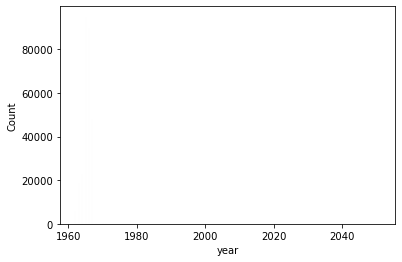

In [234]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1962
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [235]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
230688,1967.0,5.0
216853,1966.0,4.0
226500,1967.0,5.0
97141,1962.0,0.0
212404,1966.0,4.0
417491,1965.0,3.0
297620,1967.0,5.0
184939,1966.0,4.0
300477,1967.0,5.0
369159,1965.0,3.0


day:

<AxesSubplot:xlabel='day_1', ylabel='Count'>

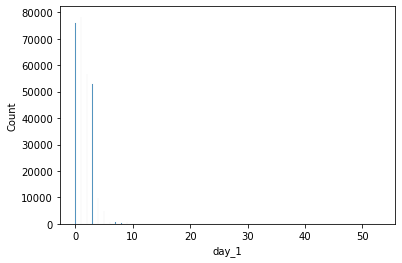

In [236]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [237]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_2', ylabel='Count'>

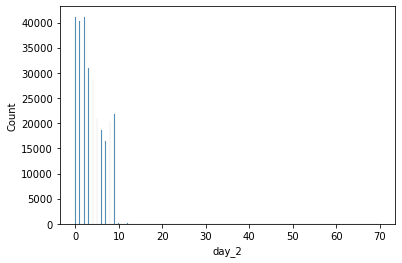

In [238]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [239]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_3', ylabel='Count'>

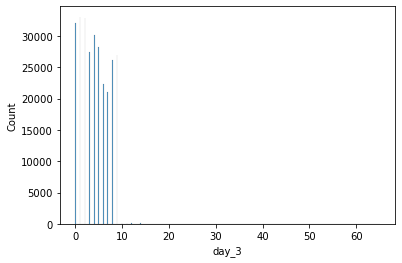

In [240]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [241]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [242]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

281336


,day_of_year,day_1,day_2,day_3
211905,312.0,3.0,1.0,2.0
367225,333.0,3.0,3.0,3.0
362575,NaN,0.0,0.0,0.0
123516,84.0,0.0,8.0,4.0
302023,148.0,1.0,4.0,8.0
369383,252.0,2.0,5.0,2.0
204825,133.0,1.0,3.0,3.0
343982,294.0,2.0,9.0,4.0
371388,21.0,0.0,2.0,1.0
305005,78.0,0.0,7.0,8.0


hour:

<AxesSubplot:xlabel='hour_1', ylabel='Count'>

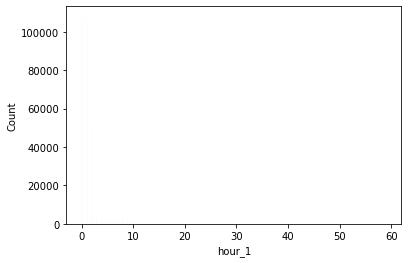

In [243]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [244]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='hour_2', ylabel='Count'>

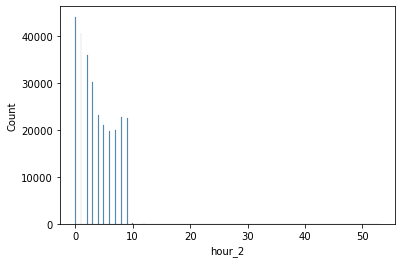

In [245]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [246]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [247]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

281336


,hour,hour_1,hour_2
210671,22.0,2.0,2.0
121251,1.0,0.0,1.0
366700,18.0,1.0,8.0
343109,20.0,2.0,0.0
273793,8.0,0.0,8.0
110555,20.0,2.0,0.0
290424,14.0,1.0,4.0
362188,0.0,0.0,0.0
176498,0.0,0.0,0.0
269635,4.0,0.0,4.0


minute:

<AxesSubplot:xlabel='minute_1', ylabel='Count'>

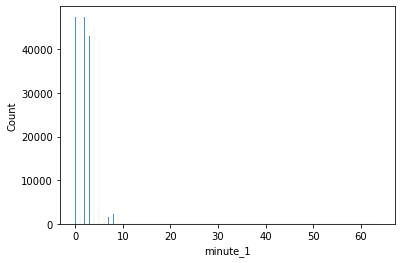

In [248]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [249]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='minute_2', ylabel='Count'>

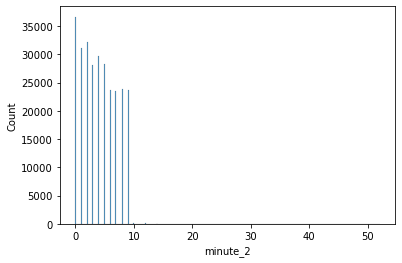

In [250]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [251]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [252]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

281336


,minute,minute_1,minute_2
346209,NaN,6.0,5.0
298393,3.0,0.0,3.0
374594,23.0,2.0,3.0
296839,23.0,2.0,3.0
367298,NaN,9.0,4.0
153128,7.0,0.0,7.0
371301,3.0,0.0,3.0
146486,25.0,2.0,5.0
214306,11.0,1.0,1.0
163145,47.0,4.0,7.0


second:

<AxesSubplot:xlabel='second_1', ylabel='Count'>

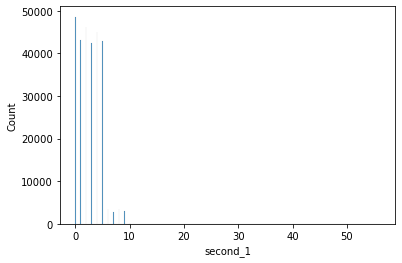

In [253]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [254]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='second_2', ylabel='Count'>

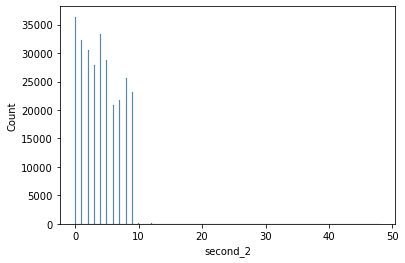

In [255]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [256]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [257]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

281336


,second,second_1,second_2
137906,46.0,4.0,6.0
368051,32.0,3.0,2.0
215394,50.0,5.0,0.0
242917,18.0,1.0,8.0
167033,54.0,5.0,4.0
258641,10.0,1.0,0.0
240541,2.0,0.0,2.0
290931,53.0,5.0,3.0
176172,5.0,0.0,5.0
313364,NaN,7.0,1.0


construct timestamp:

In [258]:
df_num = construct_timestamp(df_in=df_num)
print(len(df_num))

281336


In [259]:
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
221328,1967.0,01,05,13.0,54.0,6.0,1967-01-05 13:54:06,1
281460,1967.0,02,18,9.0,37.0,2.0,1967-02-18 09:37:02,1
125625,1964.0,11,03,22.0,57.0,22.0,1964-11-03 22:57:22,1
225908,1966.0,11,14,18.0,43.0,46.0,1966-11-14 18:43:46,1
311801,1966.0,01,25,8.0,6.0,15.0,1966-01-25 08:06:15,1
107770,1964.0,10,18,0.0,27.0,20.0,1964-10-18 00:27:20,1
141122,1965.0,08,10,6.0,54.0,52.0,1965-08-10 06:54:52,1
384382,1965.0,08,22,1.0,54.0,58.0,1965-08-22 01:54:58,1
340603,1965.0,07,30,5.0,0.0,26.0,1965-07-30 05:00:26,1
370970,1966.0,01,15,14.0,11.0,20.0,1966-01-15 14:11:20,1


#  

#### dot - check timestamp components, construct timestamp:

In [260]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot
154269,NaN,8.0,10.0,12.0,0.0,6.0,2.0,0.0,2.0,9.0,NaN
83910,NaN,8.0,8.0,12.0,4.0,16.0,1.0,8.0,0.0,0.0,NaN
407454,NaN,12.0,2.0,8.0,8.0,12.0,0.0,8.0,8.0,9.0,NaN
85320,NaN,4.0,6.0,0.0,6.0,6.0,6.0,7.0,4.0,0.0,NaN
156953,NaN,0.0,4.0,5.0,1.0,4.0,7.0,2.0,2.0,2.0,NaN
405623,NaN,0.0,0.0,2.0,10.0,0.0,4.0,4.0,0.0,10.0,NaN
115768,NaN,16.0,8.0,16.0,8.0,2.0,2.0,8.0,2.0,4.0,NaN
161317,NaN,6.0,5.0,4.0,0.0,3.0,1.0,2.0,1.0,7.0,NaN
161364,NaN,6.0,5.0,4.0,4.0,0.0,4.0,5.0,2.0,0.0,NaN
162389,NaN,12.0,8.0,0.0,0.0,16.0,9.0,4.0,8.0,8.0,NaN


day:

<AxesSubplot:xlabel='day_1', ylabel='Count'>

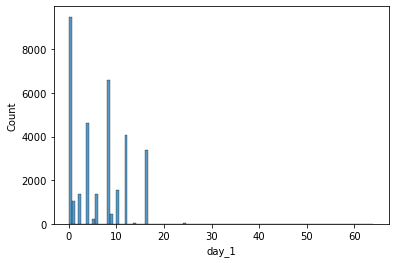

In [261]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [262]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_2', ylabel='Count'>

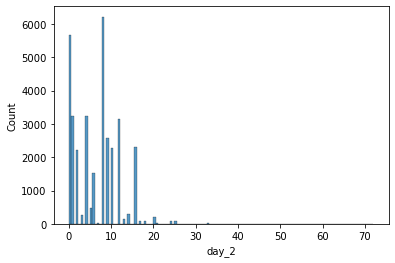

In [263]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [264]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='day_3', ylabel='Count'>

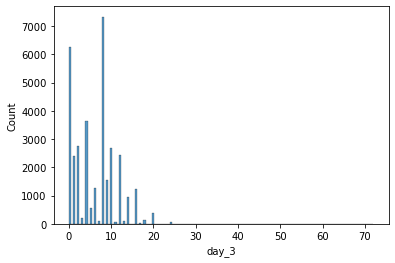

In [265]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [266]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [267]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

34291


,day_of_year,day_1,day_2,day_3
110869,NaN,1.0,NaN,8.0
397776,NaN,8.0,NaN,NaN
157106,NaN,0.0,9.0,NaN
407466,NaN,NaN,2.0,0.0
405303,NaN,0.0,0.0,NaN
113536,64.0,0.0,6.0,4.0
158924,NaN,0.0,NaN,2.0
88581,NaN,4.0,1.0,1.0
394907,NaN,8.0,0.0,NaN
110842,NaN,NaN,9.0,NaN


year - infer from day:

In [268]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

c:\DevSoftware\Anaconda38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,year,day_of_year,day_1,day_2,day_3
405413,NaN,NaN,2.0,NaN,0.0
93393,NaN,NaN,NaN,0.0,8.0
398570,NaN,NaN,1.0,NaN,8.0
90889,1963.0,251.0,2.0,5.0,1.0
401986,NaN,NaN,8.0,1.0,0.0
406653,NaN,NaN,NaN,NaN,0.0
399960,NaN,NaN,0.0,8.0,NaN
408570,NaN,NaN,8.0,8.0,4.0
114557,NaN,NaN,NaN,4.0,1.0
88490,NaN,NaN,4.0,1.0,NaN


hour:

<AxesSubplot:xlabel='hour_1', ylabel='Count'>

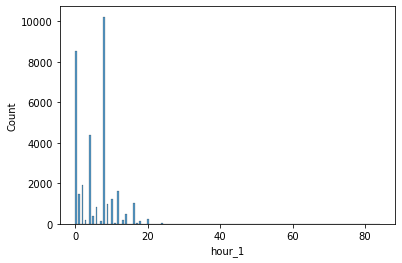

In [269]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [270]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='hour_2', ylabel='Count'>

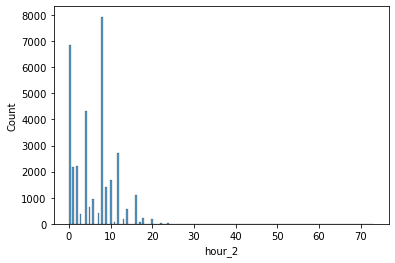

In [271]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [272]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [273]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

34291


,hour,hour_1,hour_2
153485,2.0,0.0,2.0
119150,8.0,0.0,8.0
403760,NaN,NaN,NaN
154099,4.0,0.0,4.0
409871,NaN,NaN,NaN
90154,NaN,2.0,8.0
162666,18.0,1.0,8.0
394123,NaN,4.0,NaN
90886,10.0,1.0,0.0
83001,NaN,NaN,8.0


minute:

<AxesSubplot:xlabel='minute_1', ylabel='Count'>

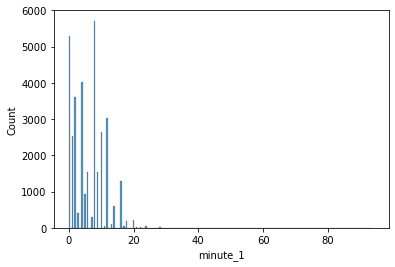

In [274]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [275]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='minute_2', ylabel='Count'>

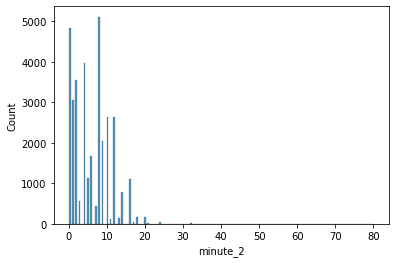

In [276]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [277]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [278]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

34291


,minute,minute_1,minute_2
161499,1.0,0.0,1.0
408818,NaN,NaN,0.0
409666,NaN,NaN,2.0
400448,NaN,8.0,1.0
117343,NaN,8.0,0.0
112165,NaN,6.0,4.0
156824,NaN,0.0,NaN
85170,15.0,1.0,5.0
157182,NaN,7.0,1.0
120150,NaN,8.0,NaN


second:

<AxesSubplot:xlabel='second_1', ylabel='Count'>

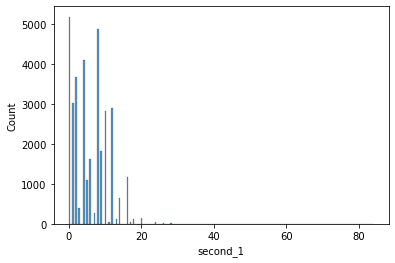

In [279]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [280]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='second_2', ylabel='Count'>

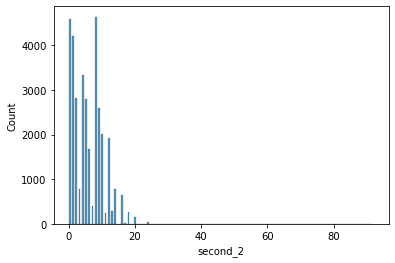

In [281]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [282]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [283]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

34291


,second,second_1,second_2
397833,21.0,2.0,1.0
153986,NaN,6.0,0.0
160347,26.0,2.0,6.0
153752,44.0,4.0,4.0
158719,NaN,4.0,NaN
117826,NaN,4.0,NaN
158521,14.0,1.0,4.0
397758,NaN,NaN,1.0
161257,10.0,1.0,0.0
396829,44.0,4.0,4.0


construct timestamp:

In [284]:
df_dot = construct_timestamp(df_in=df_dot)
print(len(df_dot))

34291


In [285]:
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
162194,NaN,NaN,NaN,NaN,8.0,NaN,NaT,0
117835,NaN,NaN,NaN,NaN,1.0,NaN,NaT,0
407968,1963.0,09,05,NaN,NaN,NaN,1963-09-05,4
396830,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
90798,1963.0,01,23,NaN,NaN,5.0,1963-01-23,4
154126,NaN,NaN,NaN,NaN,40.0,NaN,NaT,0
154167,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
393300,NaN,NaN,NaN,0.0,NaN,0.0,NaT,0
403630,NaN,NaN,NaN,5.0,8.0,NaN,NaT,0
120703,NaN,NaN,NaN,NaN,NaN,18.0,NaT,0


#  

#### Check station number:

num2:

<AxesSubplot:xlabel='station_number_OCR', ylabel='Count'>

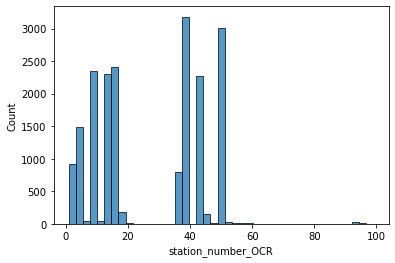

In [286]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [287]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
37315,14.0,14.0
24388,38.0,38.0
9969,38.0,38.0
53555,50.0,50.0
255172,50.0,50.0
1160,8.0,8.0
68578,50.0,50.0
67575,50.0,50.0
22054,38.0,38.0
70873,5.0,5.0


num:

<AxesSubplot:xlabel='station_number_1', ylabel='Count'>

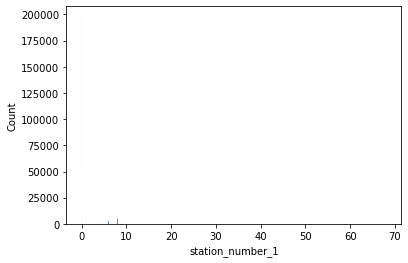

In [288]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [289]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<AxesSubplot:xlabel='station_number_2', ylabel='Count'>

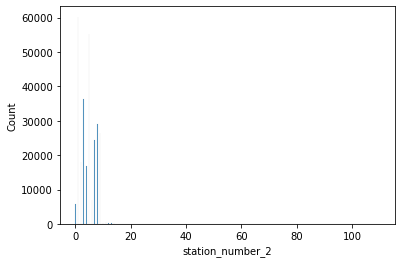

In [290]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [291]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [292]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

281336


,station_number,station_number_1,station_number_2
180783,1.0,0.0,1.0
392925,8.0,0.0,8.0
74246,5.0,0.0,5.0
196441,3.0,0.0,3.0
311353,1.0,0.0,1.0
166944,3.0,0.0,3.0
243818,1.0,0.0,1.0
209400,12.0,1.0,2.0
381131,5.0,0.0,5.0
313440,75.0,7.0,5.0


dot:

In [293]:
df_dot[['station_number']].sample(10)

,station_number
393561,5.0
92714,0.0
405668,0.0
407257,0.0
85520,0.0
158459,4.0
119193,17.0
119718,18.0
111097,0.0
393417,1.0


#  

#### Recombine results, save:

In [294]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

418972


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,year,day_of_year,hour,minute,second,time_quality,month_day,month,day,Timestamp
147212,R014207939,876-A,329.png,num,1.649194,1215.686275,1.0,0.0,1.0,3.0,...,1965.0,118.0,19.0,27.0,4.0,1.0,04-28,04,28,1965-04-28 19:27:04
353225,R014207967,1443-5A,319.png,num,1.770161,1407.547170,75.0,7.0,5.0,1.0,...,1963.0,336.0,1.0,33.0,14.0,1.0,12-02,12,02,1963-12-02 01:33:14
150824,R014207939,894-A,245.png,num,1.608871,1248.076923,51.0,5.0,1.0,3.0,...,1965.0,134.0,1.0,55.0,25.0,1.0,05-14,05,14,1965-05-14 01:55:25
205746,R014207948,1710-5A,49.png,num,1.500000,1429.629630,5.0,0.0,5.0,4.0,...,1966.0,NaN,19.0,4.0,29.0,0.0,NaN,NaN,NaN,NaT
269475,R014207957,2600-18B,137.png,num,1.500000,1274.193548,18.0,1.0,8.0,5.0,...,1967.0,30.0,6.0,29.0,30.0,1.0,01-30,01,30,1967-01-30 06:29:30
174283,R014207943,2066-3A,306.png,num,1.528226,621.153846,3.0,0.0,3.0,4.0,...,1966.0,364.0,4.0,9.0,26.0,1.0,12-30,12,30,1966-12-30 04:09:26
323766,R014207964,1620-4A,72.png,num,1.754032,4071.428571,4.0,0.0,4.0,4.0,...,1966.0,36.0,21.0,12.0,3.0,1.0,02-05,02,05,1966-02-05 21:12:03
355365,R014207968,1212-5A,304.png,num,1.500000,1220.408163,5.0,0.0,5.0,3.0,...,1965.0,225.0,12.0,11.0,0.0,1.0,08-13,08,13,1965-08-13 12:11:00
325236,R014207965,1627-4A,166.png,num,1.608871,494.444444,4.0,0.0,4.0,4.0,...,1966.0,61.0,3.0,42.0,32.0,1.0,03-02,03,02,1966-03-02 03:42:32
76029,R014207844,2904-50B,102.png,loss,1.983871,1304.166667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


Save:

In [295]:
df_result2.to_csv(resultDir + 'result_postprocess_raw.csv', index=False)

#  

#### Retrieve station details:

In [296]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [297]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [298]:
#df_result_pp = pd.read_csv(resultDir + 'result_postprocess_raw.csv')
df_result2 = df_result2.loc[~pd.isna(df_result2['station_number'])]

In [299]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
3481
1963-04-25 00:00:00
9667
1963-08-06 00:00:00
11328
1965-07-01 00:00:00
82051
After 1965-07-01 00:00:00
285666


In [300]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [301]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

285666


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
281194,19.0,1966-10-31 15:50:00,ULA,"University of Alaska, Fairbanks, AK, USA",65N,147.5W
35623,5.0,1965-04-01 07:58:01,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
229973,1.0,1966-05-10 21:57:14,BPT,"Blossom Point, MD, USA",38.4N,77.1W
277753,4.0,1965-11-15 07:06:20,NEW,"St. John's, NL, Canada",47.6N,52.4W
267345,3.0,1965-11-28 19:10:09,FTM,"Fort Myers, FL, USA",26.6N,81.9W
92902,50.0,1965-12-13 06:13:24,OTT,"Ottawa, Canada",45.4N,75.7W
211987,5.0,1967-05-10 01:40:34,QUI,"Quito, Ecuador",0.6S,78.6W
174595,1.0,1967-01-26 03:41:14,BPT,"Blossom Point, MD, USA",38.4N,77.1W
47623,63.0,1965-01-02 14:30:11,MAD,"Tananarive, Madagascar",19S,47.3E
33790,5.0,1965-03-29 04:54:08,COL,"College, Fairbanks, AK, USA",64.9N,147.8W


#  

#### Save Master:

In [302]:
df_result5 = df_result4[~pd.isna(df_result4['Station_Code'])]
df_result5 = df_result5[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 'Timestamp',
                         'time_quality', 'Station_Number', 'Station_Code', 'Station_Name', 'Lat', 'Lng']]
print(len(df_result5))
df_result5.sample(10)

262124


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,Timestamp,time_quality,Station_Number,Station_Code,Station_Name,Lat,Lng
178643,R014207954,2227-18B,71.png,num,1.504032,3818.750000,1966-10-28 19:33:30,1.0,19.0,ULA,"University of Alaska, Fairbanks, AK, USA",65N,147.5W
136985,R014207947,1891-12A,17.png,num,1.786290,1179.629630,1966-07-13 00:45:49,1.0,12.0,NEW,"St. John's, NL, Canada",47.6N,52.4W
165711,R014207953,2674-13B,116.png,num,1.568548,520.370370,1967-01-05 06:17:43,1.0,13.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
77140,R014207929F,444,Image0202.png,num,1.500000,2183.870968,1965-03-31 00:00:00,4.0,15.0,SPT,"South Point, HI, USA",18.9N,155.7W
165032,R014207953,2670-13B,147.png,num,1.504032,685.185185,1966-12-25 07:35:24,1.0,13.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
205817,R014207959,2322-1B,298.png,num,1.500000,1019.642857,1967-02-22 22:13:03,1.0,1.0,BPT,"Blossom Point, MD, USA",38.4N,77.1W
277940,R014207980,979-B,226.png,num,1.641129,1192.307692,1965-11-20 17:49:11,1.0,4.0,NEW,"St. John's, NL, Canada",47.6N,52.4W
27951,R014207929F,435,Image0235.png,num,1.500000,1396.774194,1965-03-13 18:35:09,1.0,3.0,OTT,"Ottawa, Canada",45.4N,75.7W
210106,R014207959,2347-7A,228.png,num,1.790323,1046.153846,1966-06-23 04:55:30,1.0,7.0,QUI,"Quito, Ecuador",0.6S,78.6W
212614,R014207960,2548-5B,113.png,num,1.532258,1345.454545,1967-05-18 22:25:52,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W


In [303]:
df_result5 = df_result5.sort_values('Timestamp').reset_index(drop=True)
df_result5.to_csv(resultDir + 'result_master.csv', index=False)